In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import shutil
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
import pandas as pd

In [2]:
def plot_categories(training_images, training_labels,mapping = None, count = 10):
  fig, axes = plt.subplots(int(np.sqrt(count))+1, int(np.sqrt(count))+1, figsize=(16, 15))
  axes = axes.flatten()
    
  for ax in axes:
    ax.set_axis_off()

  for k in range(count):
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.set_axis_on()
    ax.imshow(img, cmap="Greys_r")
    label = None
    if mapping:
        label = mapping[training_labels[k]]
    else:
        label = training_labels[k]
        
    ax.set_title(label)
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

In [3]:

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
    
    
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-tumor detected (True Negatives): ', cm[0][0])
  print('Non-tumor incorrectly detected (False Positives): ', cm[0][1])
  print('Tumor missed (False Negatives): ', cm[1][0])
  print('Tumor detected (True Positives): ', cm[1][1])
  print('Total case: ', np.sum(cm[1]))

In [4]:
data_path = pathlib.Path("dataport-dataset/")
data_path = os.path.join(data_path, os.listdir(data_path)[0])

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 425 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


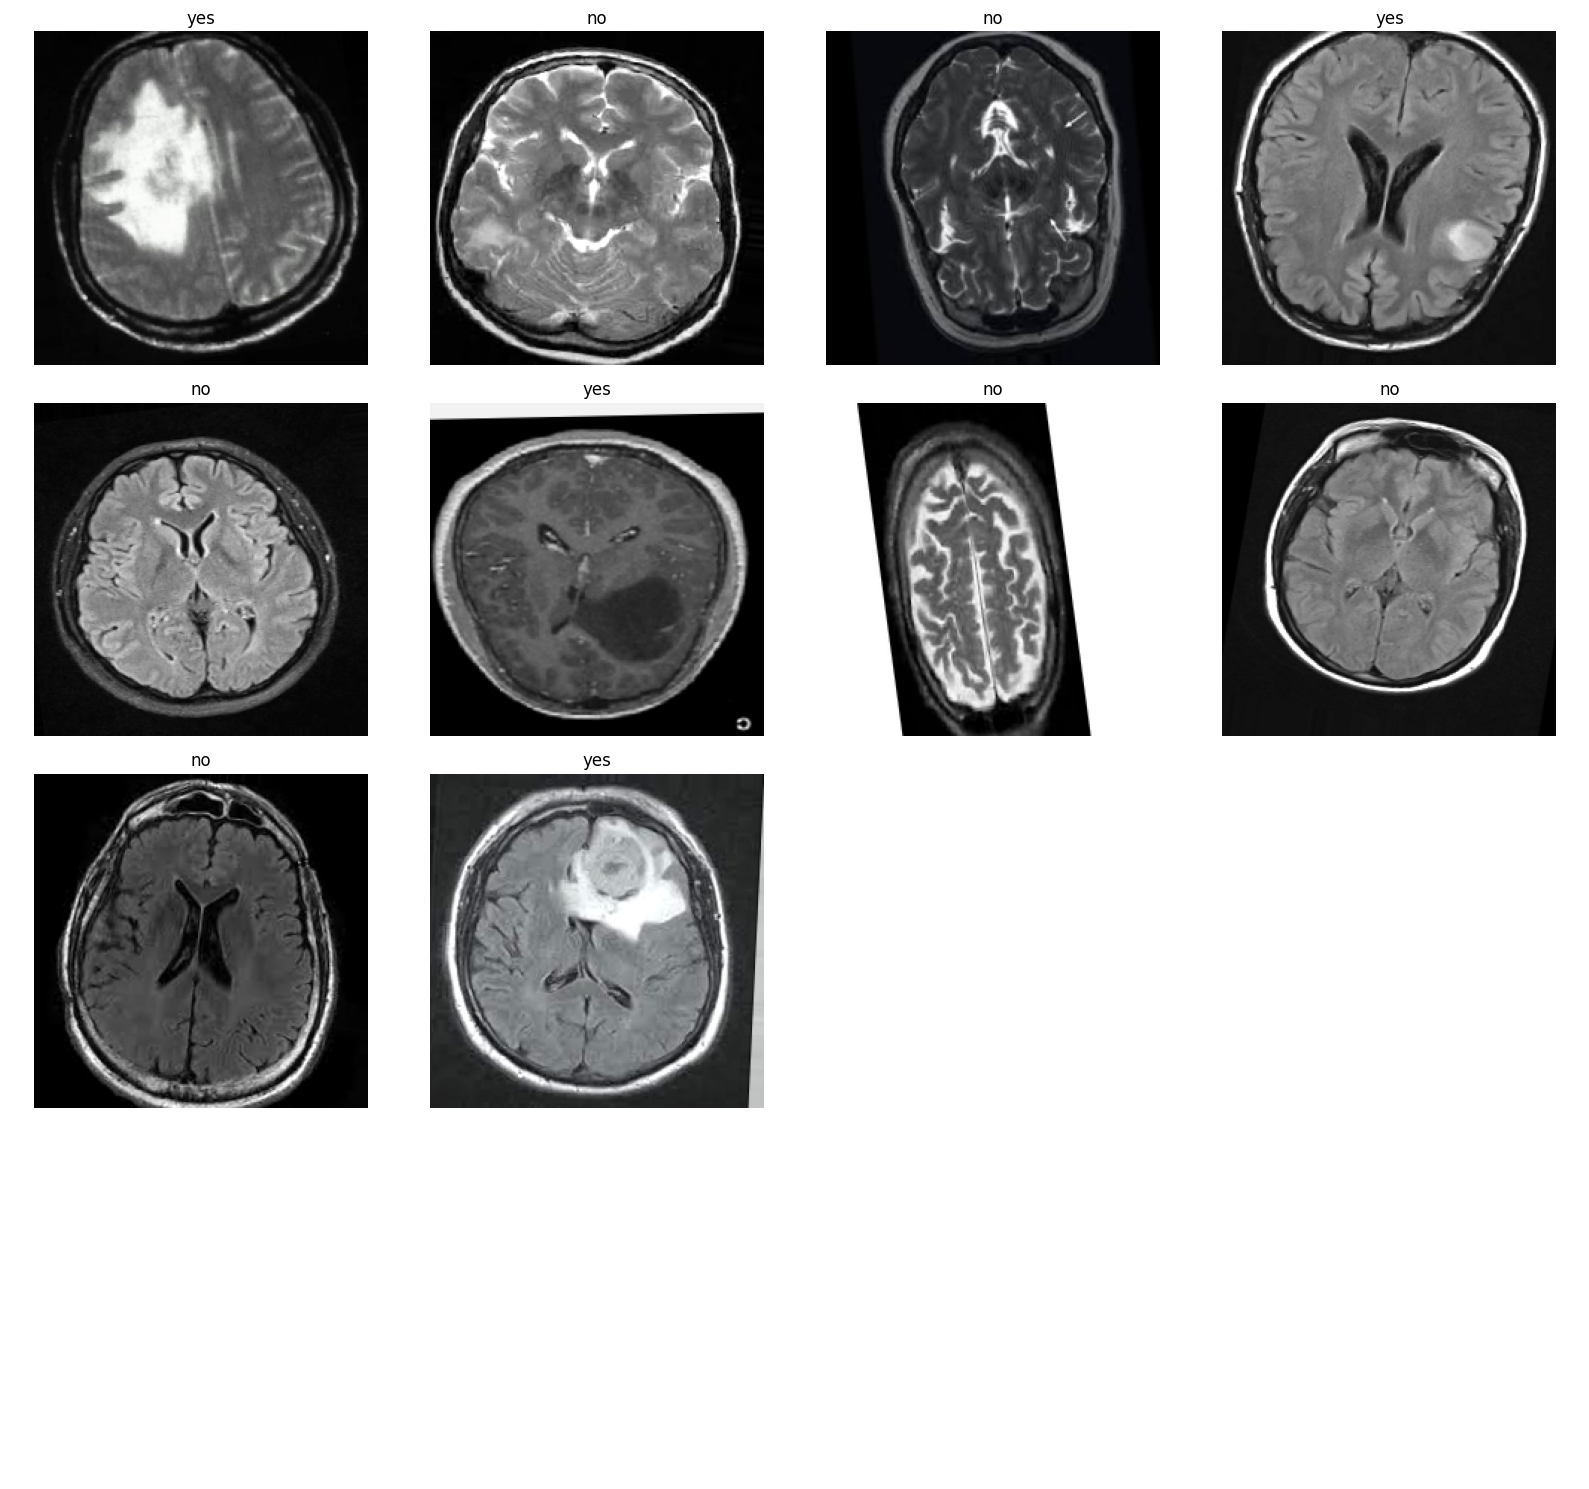

In [6]:
sample_X, sample_y = next(train_generator)
mapping = {1: "yes", 0: "no"}

plot_categories(sample_X, sample_y, mapping, sample_X.shape[0])


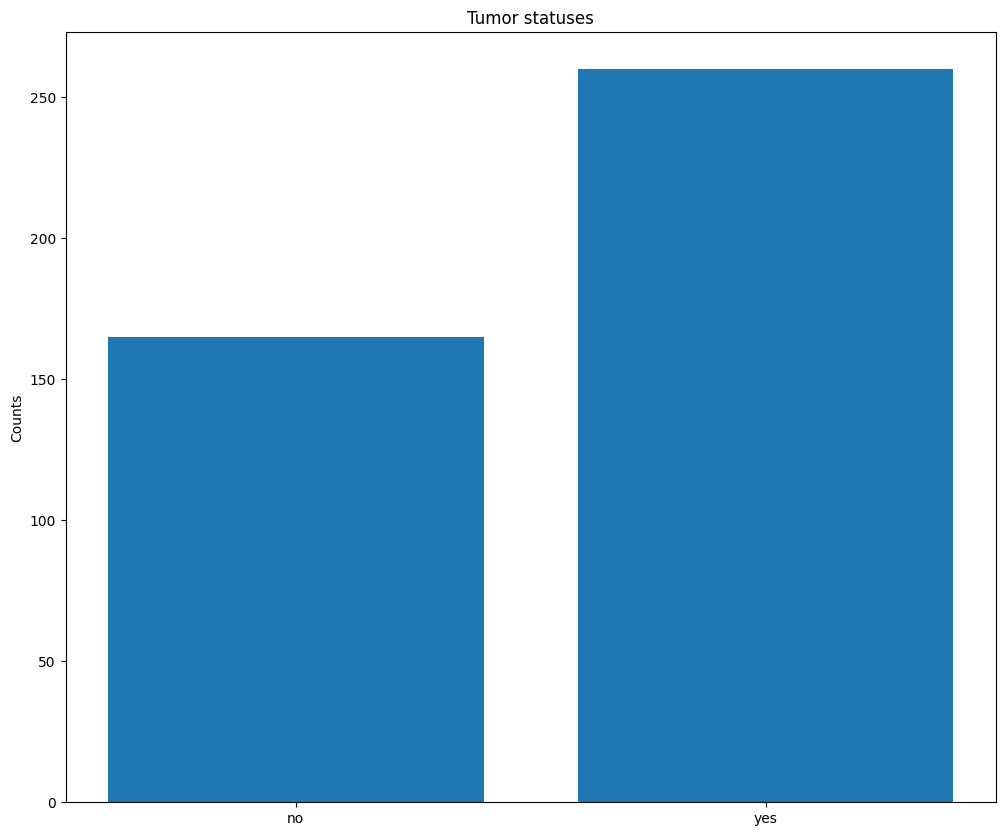

In [7]:
labels, counts = np.unique(train_generator.labels, return_counts = True)
labels = [mapping[l] for l in labels]

fig, ax = plt.subplots()
ax.set_ylabel('Counts')
ax.set_title('Tumor statuses')
ax.bar(labels, counts)

plt.show()

In [8]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
train_class_weights = dict(enumerate(class_weights))


In [9]:
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

# SIMPLE LENET CNN MODEL

In [10]:
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3), activation="relu", input_shape=(224,224,3)),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 512 , activation="relu"),
      tf.keras.layers.Dropout(rate = 0.5),
      tf.keras.layers.Dense(units = 1 , activation="sigmoid")
  ])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
                loss = "binary_crossentropy",
                metrics=metrics)

tf.keras.utils.plot_model(model) # image of models structure you can get from output folder
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,345 (3.18 MB)

 Trainable params: 833,345 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# EPOCH SIZE 10
history1 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5831 - auc: 0.6225 - fn: 44.5909 - fp: 39.1136 - loss: 0.6775 - prc: 0.6774 - precision: 0.6458 - recall: 0.6117 - tn: 47.2500 - tp: 90.2955 - val_accuracy: 0.6981 - val_auc: 0.7752 - val_fn: 18.0000 - val_fp: 14.0000 - val_loss: 0.6187 - val_prc: 0.8572 - val_precision: 0.7705 - val_recall: 0.7231 - val_tn: 27.0000 - val_tp: 47.0000
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.7606 - auc: 0.8390 - fn: 31.5909 - fp: 21.4545 - loss: 0.5177 - prc: 0.8443 - precision: 0.8330 - recall: 0.7370 - tn: 65.6364 - tp: 103.7045 - val_accuracy: 0.7547 - val_auc: 0.8049 - val_fn: 7.0000 - val_fp: 19.0000 - val_loss: 0.5397 - val_prc: 0.8674 - val_precision: 0.7532 - val_recall: 0.8923 - val_tn: 22.0000 - val_tp: 58.0000
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.8024 - auc: 0.8313 - fn: 25.5682 - fp: 21.3182 - loss: 0.5209 - prc: 0.8500 - precision: 0.8501 - recall: 0.8227 - tn: 64.6591 - t

In [13]:
validation_results0 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results0):
  print(name, ': ', value)

loss :  0.4813673198223114
compile_metrics :  58.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Non-tumor detected (True Negatives):  25
Non-tumor incorrectly detected (False Positives):  16
Tumor missed (False Negatives):  8
Tumor detected (True Positives):  57
Total case:  65


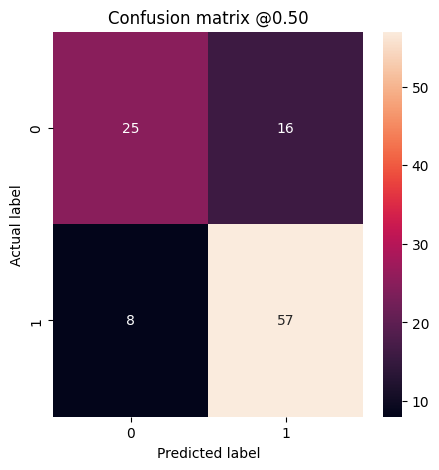

In [14]:
validation_predictions0 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions0)

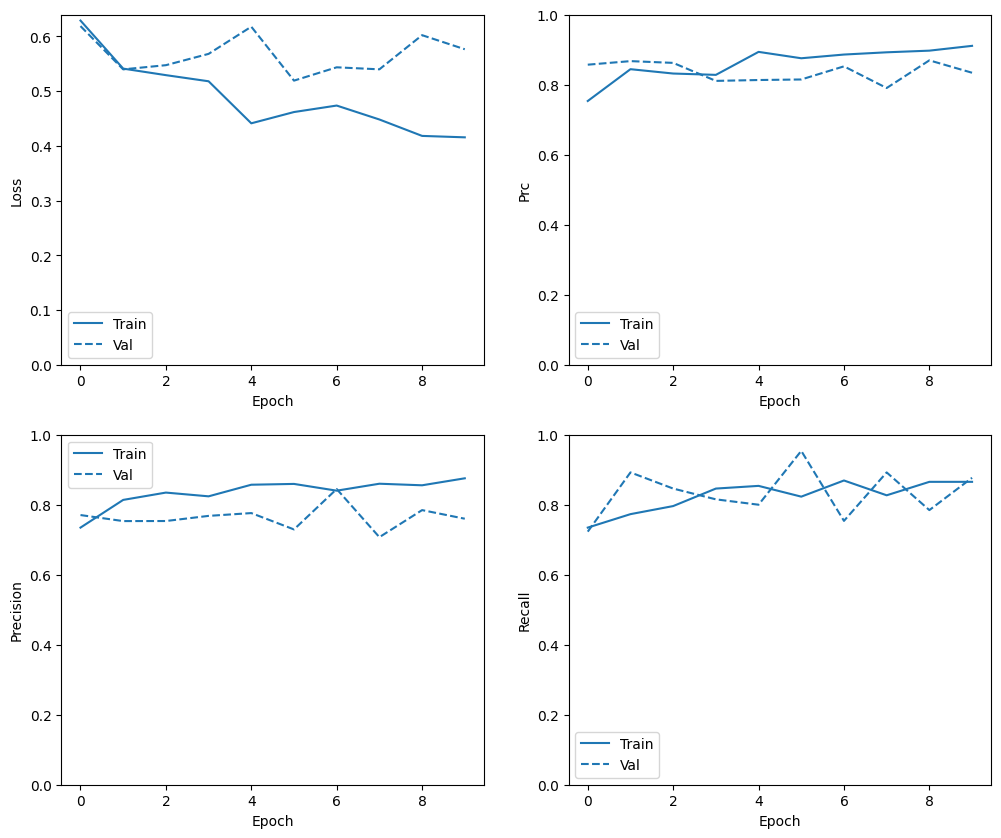

In [15]:
plot_metrics(history1)

In [16]:
# EPOCH SIZE 20
history2 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.8235 - auc: 0.8967 - fn: 17.2500 - fp: 20.6591 - loss: 0.3995 - prc: 0.9075 - precision: 0.8383 - recall: 0.8666 - tn: 68.7273 - tp: 116.0909 - val_accuracy: 0.7925 - val_auc: 0.8321 - val_fn: 11.0000 - val_fp: 11.0000 - val_loss: 0.5483 - val_prc: 0.8766 - val_precision: 0.8308 - val_recall: 0.8308 - val_tn: 30.0000 - val_tp: 54.0000
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.8556 - auc: 0.9320 - fn: 16.5000 - fp: 15.4773 - loss: 0.3471 - prc: 0.9512 - precision: 0.8996 - recall: 0.8558 - tn: 70.6818 - tp: 117.5682 - val_accuracy: 0.8019 - val_auc: 0.8128 - val_fn: 10.0000 - val_fp: 11.0000 - val_loss: 0.5893 - val_prc: 0.8211 - val_precision: 0.8333 - val_recall: 0.8462 - val_tn: 30.0000 - val_tp: 55.0000
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8276 - auc: 0.8938 - fn: 18.5227 - fp: 19.1818 - loss: 0.3978 - prc: 0.9116 - precision: 0.8603 - recall: 0.8527 - tn: 65.4773 -

In [17]:
validation_results2 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results2):
  print(name, ': ', value)

loss :  0.4955446124076843
compile_metrics :  57.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Non-tumor detected (True Negatives):  29
Non-tumor incorrectly detected (False Positives):  12
Tumor missed (False Negatives):  9
Tumor detected (True Positives):  56
Total case:  65


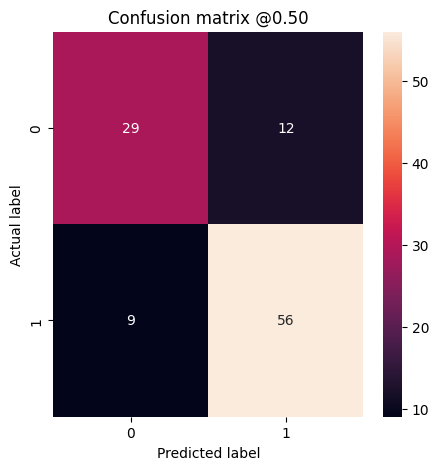

In [18]:
validation_predictions2 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions2)

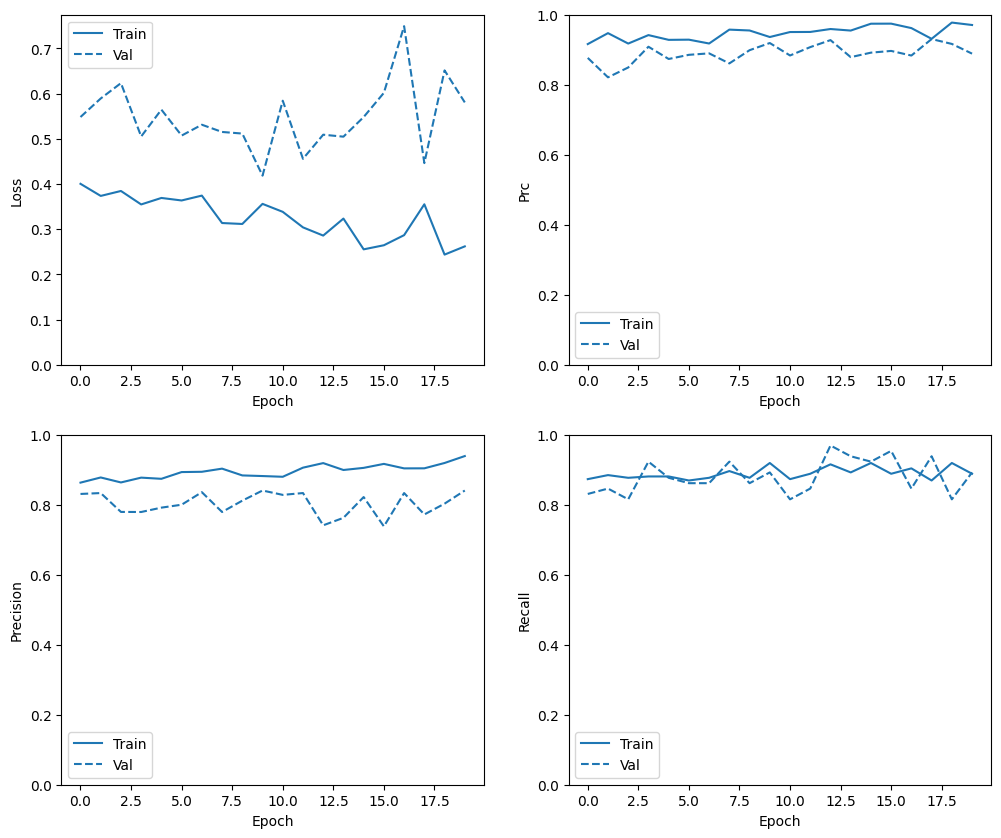

In [19]:
plot_metrics(history2)

In [21]:
# EPOCH SIZE 40
history3 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9195 - auc: 0.9699 - fn: 9.4091 - fp: 9.4545 - loss: 0.2334 - prc: 0.9816 - precision: 0.9301 - recall: 0.9403 - tn: 76.2273 - tp: 127.4091 - val_accuracy: 0.8113 - val_auc: 0.9069 - val_fn: 10.0000 - val_fp: 10.0000 - val_loss: 0.5565 - val_prc: 0.9456 - val_precision: 0.8462 - val_recall: 0.8462 - val_tn: 31.0000 - val_tp: 55.0000
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9309 - auc: 0.9816 - fn: 8.2045 - fp: 6.4773 - loss: 0.1715 - prc: 0.9890 - precision: 0.9552 - recall: 0.9323 - tn: 77.1136 - tp: 127.9773 - val_accuracy: 0.8396 - val_auc: 0.9002 - val_fn: 6.0000 - val_fp: 11.0000 - val_loss: 0.4408 - val_prc: 0.9317 - val_precision: 0.8429 - val_recall: 0.9077 - val_tn: 30.0000 - val_tp: 59.0000
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9354 - auc: 0.9801 - fn: 8.3409 - fp: 7.3182 - loss: 0.1842 - prc: 0.9865 - precision: 0.9463 - recall: 0.9408 - tn: 83.8409 - tp: 12

In [22]:
validation_results3 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results3):
  print(name, ': ', value)

loss :  0.9237119555473328
compile_metrics :  56.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Non-tumor detected (True Negatives):  33
Non-tumor incorrectly detected (False Positives):  8
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  58
Total case:  65


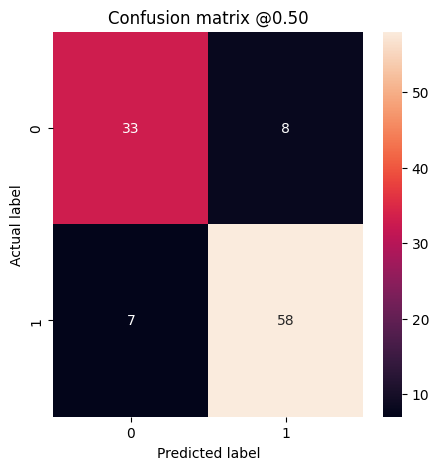

In [23]:
validation_predictions3 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions3)

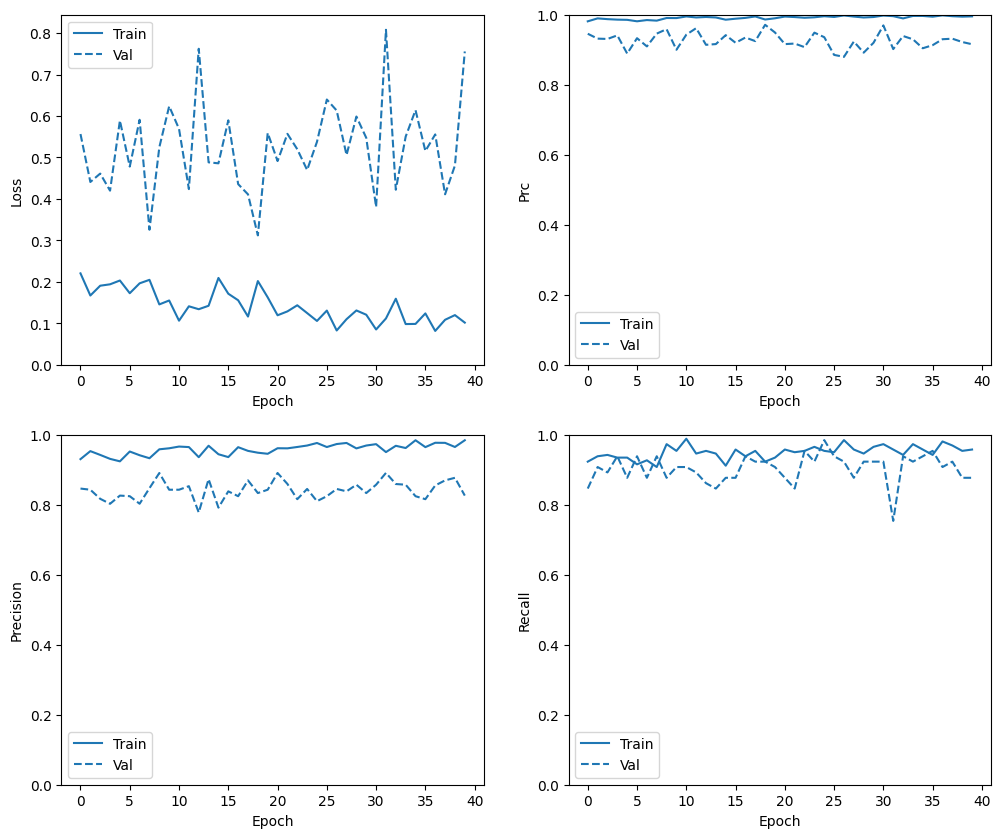

In [24]:
plot_metrics(history3)

# RESNETV2 MODEL

In [25]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,252,193 (226.03 MB)

 Trainable params: 4,915,457 (18.75 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [26]:
history4 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 694ms/step - accuracy: 0.7556 - auc: 0.8142 - fn: 45.0227 - fp: 34.6591 - loss: 0.9456 - prc: 0.8463 - precision: 0.8212 - recall: 0.7851 - tn: 87.0227 - tp: 162.3636 - val_accuracy: 0.8019 - val_auc: 0.9205 - val_fn: 14.0000 - val_fp: 7.0000 - val_loss: 0.3826 - val_prc: 0.9397 - val_precision: 0.8793 - val_recall: 0.7846 - val_tn: 34.0000 - val_tp: 51.0000
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 626ms/step - accuracy: 0.8763 - auc: 0.9447 - fn: 18.2500 - fp: 10.3864 - loss: 0.3051 - prc: 0.9618 - precision: 0.9276 - recall: 0.8715 - tn: 71.8636 - tp: 120.6364 - val_accuracy: 0.7925 - val_auc: 0.8976 - val_fn: 11.0000 - val_fp: 11.0000 - val_loss: 0.3902 - val_prc: 0.9329 - val_precision: 0.8308 - val_recall: 0.8308 - val_tn: 30.0000 - val_tp: 54.0000
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 967ms/step - accuracy: 0.8952 - auc: 0.9548 - fn: 14.1818 - fp: 9.6818 - loss: 0.2789 - prc: 0.9678 - precision: 0.9284 - recall: 0.8925 - tn: 77.6591 

In [27]:
validation_results4 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results4):
  print(name, ': ', value)

loss :  0.5261985659599304
compile_metrics :  63.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
Non-tumor detected (True Negatives):  30
Non-tumor incorrectly detected (False Positives):  11
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  63
Total case:  65


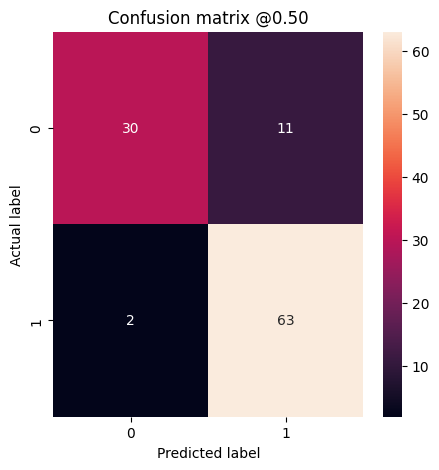

In [28]:
validation_predictions4 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions4)

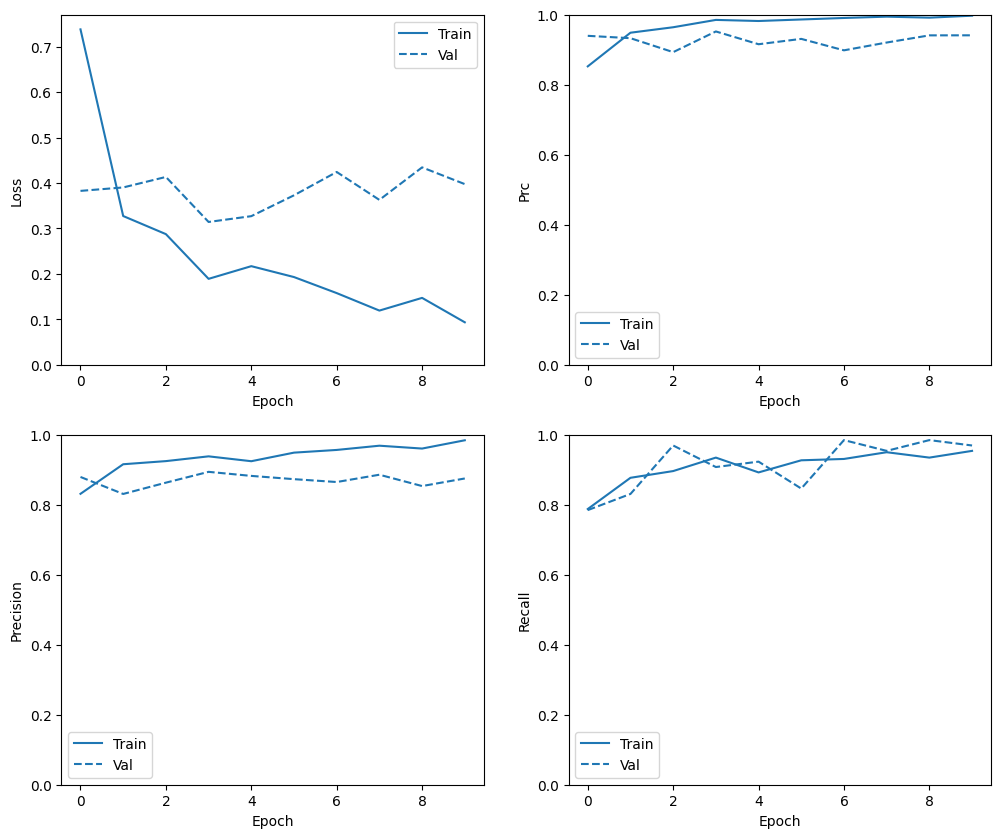

In [29]:
plot_metrics(history4)

In [31]:
# EPOCH SIZE 20
history5 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9652 - auc: 0.9973 - fn: 7.1591 - fp: 1.9545 - loss: 0.0810 - prc: 0.9982 - precision: 0.9887 - recall: 0.9529 - tn: 87.2500 - tp: 127.8409 - val_accuracy: 0.8208 - val_auc: 0.9083 - val_fn: 13.0000 - val_fp: 6.0000 - val_loss: 0.4836 - val_prc: 0.9377 - val_precision: 0.8966 - val_recall: 0.8000 - val_tn: 35.0000 - val_tp: 52.0000
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9497 - auc: 0.9927 - fn: 7.7955 - fp: 2.4091 - loss: 0.1126 - prc: 0.9958 - precision: 0.9782 - recall: 0.9398 - tn: 83.3636 - tp: 129.6136 - val_accuracy: 0.8491 - val_auc: 0.9015 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.4363 - val_prc: 0.9049 - val_precision: 0.8551 - val_recall: 0.9077 - val_tn: 31.0000 - val_tp: 59.0000
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9799 - auc: 0.9987 - fn: 2.6818 - fp: 1.4773 - loss: 0.0631 - prc: 0.9991 - precision: 0.9899 - recall: 0.9748 - tn: 87.0000 - tp: 128.8409 

In [32]:
validation_results5 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results5):
  print(name, ': ', value)

loss :  0.4529419541358948
compile_metrics :  61.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Non-tumor detected (True Negatives):  34
Non-tumor incorrectly detected (False Positives):  7
Tumor missed (False Negatives):  5
Tumor detected (True Positives):  60
Total case:  65


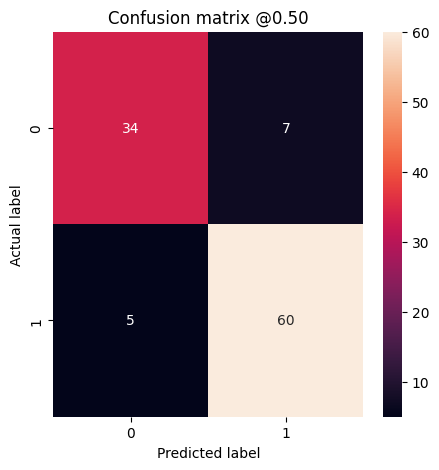

In [33]:
validation_predictions5 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions5)

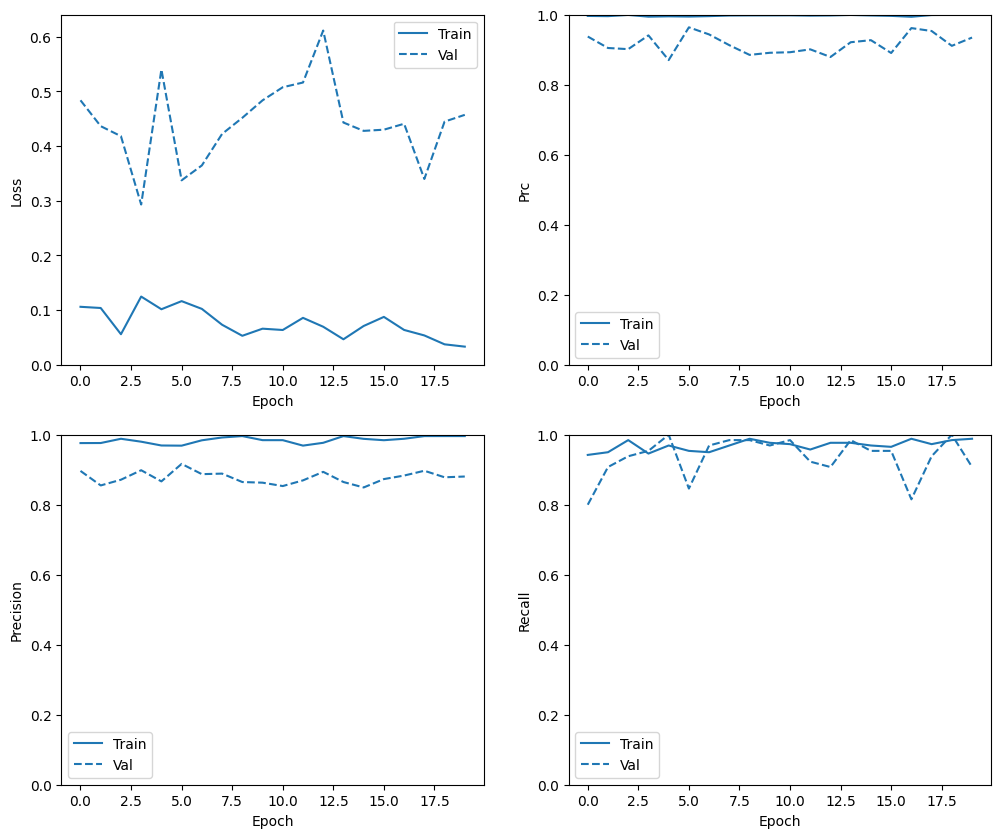

In [34]:
plot_metrics(history5)

In [35]:
# EPOCH SIZE 40
history6 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9916 - auc: 0.9998 - fn: 1.7273 - fp: 0.0000e+00 - loss: 0.0227 - prc: 0.9999 - precision: 1.0000 - recall: 0.9866 - tn: 83.4091 - tp: 135.7727 - val_accuracy: 0.8868 - val_auc: 0.9266 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.3739 - val_prc: 0.9368 - val_precision: 0.8955 - val_recall: 0.9231 - val_tn: 34.0000 - val_tp: 60.0000
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9978 - auc: 0.9772 - fn: 0.5455 - fp: 0.2955 - loss: 0.0223 - prc: 1.0000 - precision: 0.9987 - recall: 0.9977 - tn: 89.0909 - tp: 130.1818 - val_accuracy: 0.8774 - val_auc: 0.9135 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.5052 - val_prc: 0.9164 - val_precision: 0.8514 - val_recall: 0.9692 - val_tn: 30.0000 - val_tp: 63.0000
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9838 - auc: 0.9962 - fn: 1.2273 - fp: 2.1591 - loss: 0.0678 - prc: 0.9970 - precision: 0.9802 - recall: 0.9930 - tn: 85.7045 - tp: 132.50

In [36]:
validation_results6 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results6):
  print(name, ': ', value)

loss :  0.3049427568912506
compile_metrics :  62.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 959ms/step
Non-tumor detected (True Negatives):  33
Non-tumor incorrectly detected (False Positives):  8
Tumor missed (False Negatives):  4
Tumor detected (True Positives):  61
Total case:  65


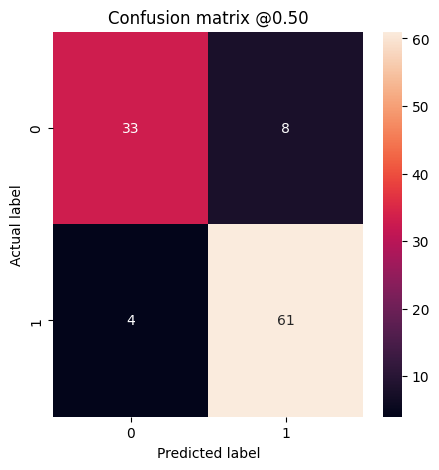

In [37]:
validation_predictions6 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions6)

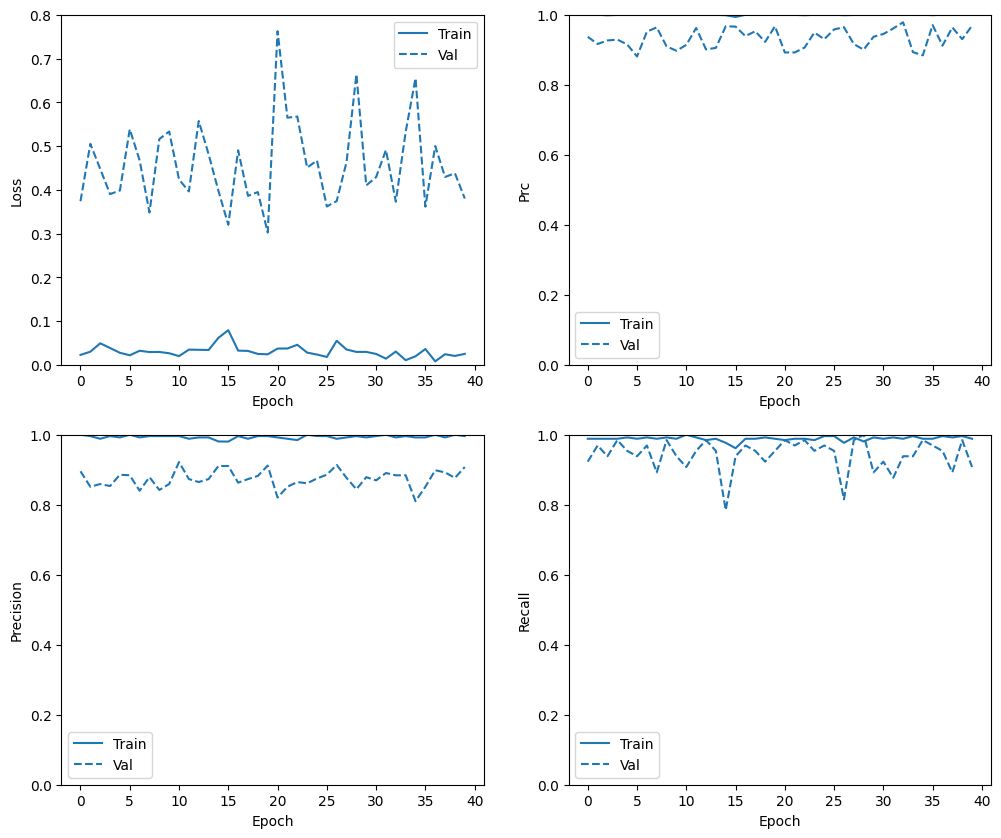

In [38]:
plot_metrics(history6)

# VGG16 MODEL

In [39]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalMaxPooling2D(),
                              tf.keras.layers.Dense(4096, activation = 'relu'),
                              tf.keras.layers.Dropout(rate=0.5),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

In [40]:
# EPOCH SIZE 10
history7 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7302 - auc: 0.8081 - fn: 45.6136 - fp: 48.5227 - loss: 0.6468 - prc: 0.8702 - precision: 0.7734 - recall: 0.8022 - tn: 74.3409 - tp: 158.4318 - val_accuracy: 0.7642 - val_auc: 0.8632 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.4887 - val_prc: 0.8864 - val_precision: 0.7564 - val_recall: 0.9077 - val_tn: 22.0000 - val_tp: 59.0000
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.8003 - auc: 0.8679 - fn: 23.7727 - fp: 23.5909 - loss: 0.4879 - prc: 0.8948 - precision: 0.8348 - recall: 0.8499 - tn: 59.8409 - tp: 115.4091 - val_accuracy: 0.8019 - val_auc: 0.8807 - val_fn: 11.0000 - val_fp: 10.0000 - val_loss: 0.4400 - val_prc: 0.9180 - val_precision: 0.8438 - val_recall: 0.8308 - val_tn: 31.0000 - val_tp: 54.0000
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.7115 - auc: 0.8108 - fn: 39.3182 - fp: 23.5227 - loss: 0.5175 - prc: 0.8864 - precision: 0.8155 - recall: 0.7194 - tn: 57.8864 - tp:

In [41]:
validation_results7 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results7):
  print(name, ': ', value)

loss :  0.3429354131221771
compile_metrics :  57.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Non-tumor detected (True Negatives):  32
Non-tumor incorrectly detected (False Positives):  9
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  58
Total case:  65


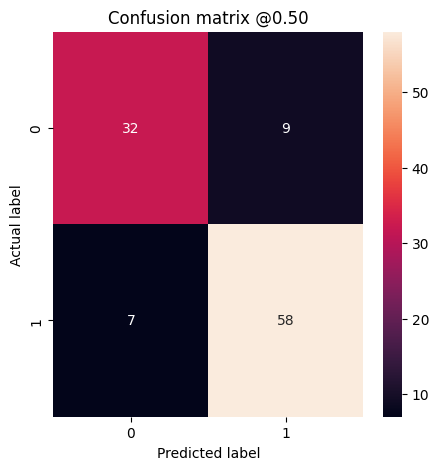

In [42]:
validation_predictions7 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions7)

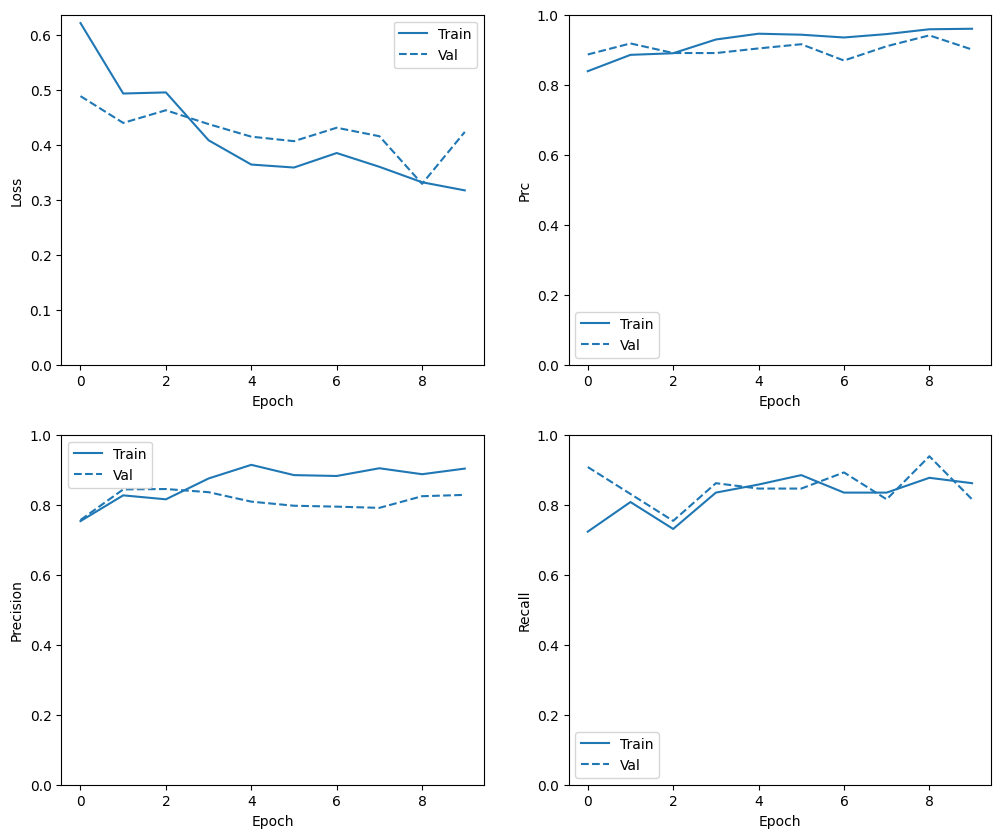

In [43]:
plot_metrics(history7)

In [44]:
# EPOCH SIZE 20
history8 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.8664 - auc: 0.9506 - fn: 17.9773 - fp: 11.9318 - loss: 0.3017 - prc: 0.9663 - precision: 0.9081 - recall: 0.8635 - tn: 76.6364 - tp: 118.0000 - val_accuracy: 0.8491 - val_auc: 0.9090 - val_fn: 9.0000 - val_fp: 7.0000 - val_loss: 0.3664 - val_prc: 0.9009 - val_precision: 0.8889 - val_recall: 0.8615 - val_tn: 34.0000 - val_tp: 56.0000
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8613 - auc: 0.9328 - fn: 15.9318 - fp: 11.7727 - loss: 0.3250 - prc: 0.9601 - precision: 0.9100 - recall: 0.8751 - tn: 71.7727 - tp: 121.7727 - val_accuracy: 0.8113 - val_auc: 0.8856 - val_fn: 4.0000 - val_fp: 16.0000 - val_loss: 0.4181 - val_prc: 0.9110 - val_precision: 0.7922 - val_recall: 0.9385 - val_tn: 25.0000 - val_tp: 61.0000
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.8892 - auc: 0.9618 - fn: 16.6364 - fp: 9.7955 - loss: 0.2706 - prc: 0.9730 - precision: 0.9156 - recall: 0.8917 - tn: 80.3636 - tp: 11

In [45]:
validation_results8 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results8):
  print(name, ': ', value)

loss :  0.42346423864364624
compile_metrics :  54.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Non-tumor detected (True Negatives):  33
Non-tumor incorrectly detected (False Positives):  8
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  58
Total case:  65


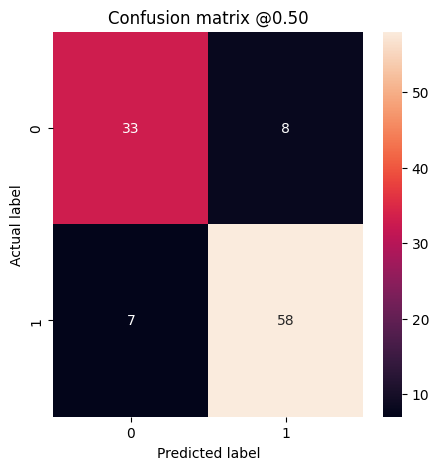

In [46]:
validation_predictions8 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions8)

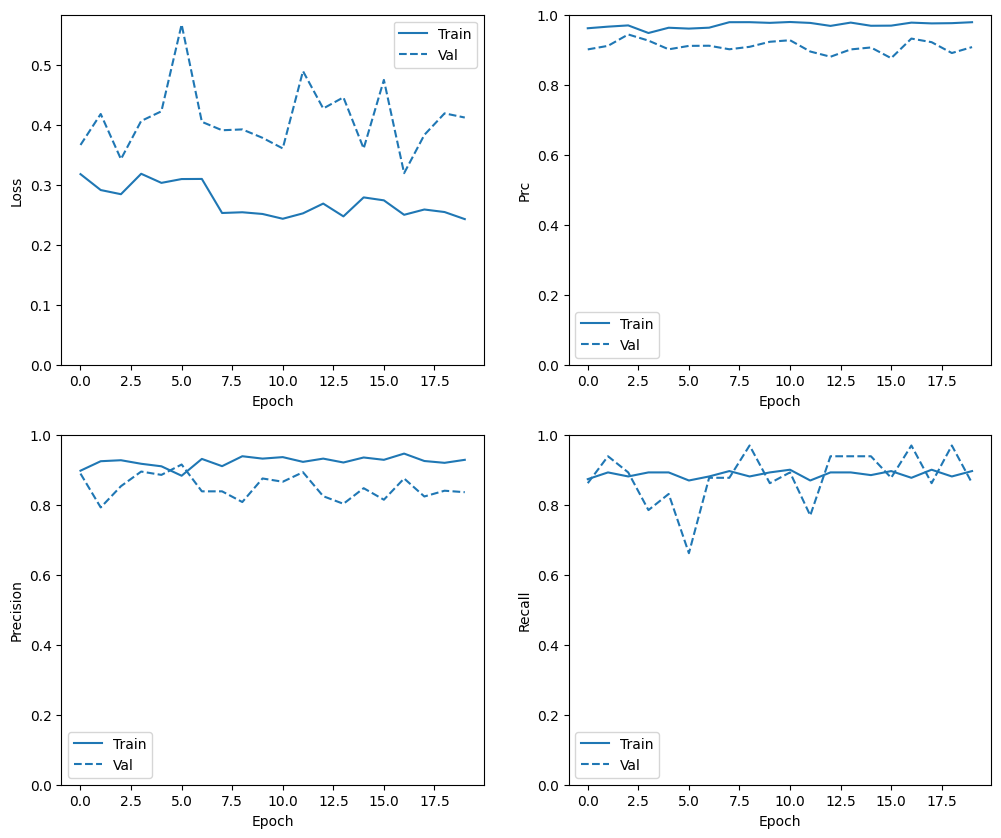

In [47]:
plot_metrics(history8)

In [48]:
# EPOCH SIZE 40
history9 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9304 - auc: 0.9840 - fn: 10.4773 - fp: 7.7273 - loss: 0.1929 - prc: 0.9909 - precision: 0.9490 - recall: 0.9417 - tn: 74.1364 - tp: 131.2955 - val_accuracy: 0.8491 - val_auc: 0.9060 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.4087 - val_prc: 0.9267 - val_precision: 0.9016 - val_recall: 0.8462 - val_tn: 35.0000 - val_tp: 55.0000
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8938 - auc: 0.9655 - fn: 12.3409 - fp: 11.1136 - loss: 0.2457 - prc: 0.9776 - precision: 0.9246 - recall: 0.9075 - tn: 74.3409 - tp: 125.6136 - val_accuracy: 0.8019 - val_auc: 0.8803 - val_fn: 11.0000 - val_fp: 10.0000 - val_loss: 0.4505 - val_prc: 0.8834 - val_precision: 0.8438 - val_recall: 0.8308 - val_tn: 31.0000 - val_tp: 54.0000
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9253 - auc: 0.9793 - fn: 10.3636 - fp: 7.9545 - loss: 0.2083 - prc: 0.9847 - precision: 0.9450 - recall: 0.9286 - tn: 80.5000 - tp: 1

In [49]:
validation_results9 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results9):
  print(name, ': ', value)

loss :  0.4288821816444397
compile_metrics :  59.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 915ms/step
Non-tumor detected (True Negatives):  33
Non-tumor incorrectly detected (False Positives):  8
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  58
Total case:  65


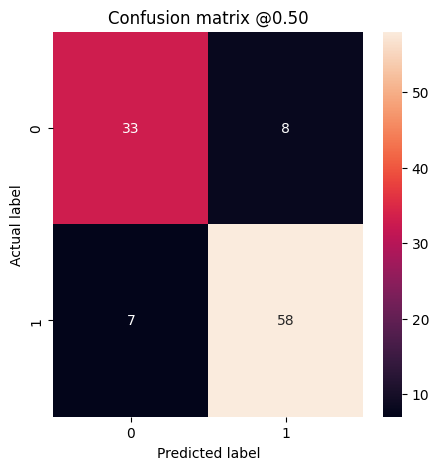

In [50]:
validation_predictions9 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions9)

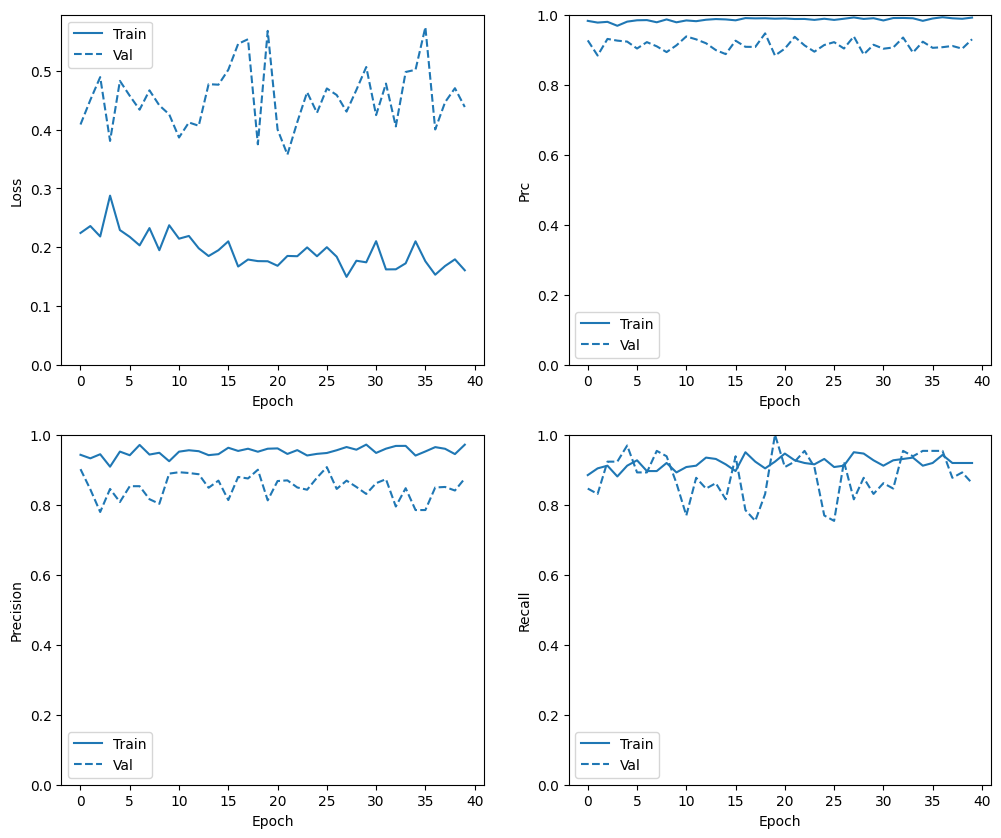

In [51]:
plot_metrics(history9)

# OVERALL RESULTS

In [52]:
res = [["Simple CNN [10 Epoch]", ],
       ["Simple CNN [20 Epoch]", ],
       ["Simple CNN [40 Epoch]", ],
       ["ResNetV2 [10 Epoch]", ],
       ["ResNetV2 [20 Epoch]", ],
       ["ResNetV2 [40 Epoch]", ],
       ["VGG16 [10 Epoch]", ],
       ["VGG16 [20 Epoch]", ], 
       ["VGG16 [40 Epoch]", ]]
histories = [history1,history2,history3,history4,history5,history6,history7,history8,history9]

for i,hist in enumerate(histories):
    
    hist_li = list(hist.history.values())
    
    acc = hist_li[15][0]
    precision = hist_li[16][0]
    recall = hist_li[17][0]
    max_auc = hist_li[18][0]
    
    mean_acc = np.mean(hist_li[15])
    mean_precision = np.mean(hist_li[16])
    mean_recall = np.mean(hist_li[17])
    mean_auc = np.mean(hist_li[18])
    
    
    for j in range(len(hist_li[16])):
        if hist_li[18][j] > max_auc: # finding epoch with maximum AUC achieved
            
            acc = hist_li[15][j]
            precision = hist_li[16][j]
            recall = hist_li[17][j]
            max_auc = hist_li[18][j]
        
    
    res[i] += [precision,recall, max_auc, acc,mean_precision, mean_recall,mean_auc,mean_acc]
    
df = pd.DataFrame(res, columns = ["Model Name", f"Precision (with Max AUC)","Recall (with Max AUC)"," Max AUC", "Accuracy",
                                 "Mean Precision", "Mean Recall","Mean AUC", "Mean Accuracy"])

df

,Model Name,Precision (with Max AUC),Recall (with Max AUC),Max AUC,Accuracy,Mean Precision,Mean Recall,Mean AUC,Mean Accuracy
0,Simple CNN [10 Epoch],0.844828,0.753846,32.0,0.852500,0.764757,0.833846,24.000,0.837339
1,Simple CNN [20 Epoch],0.830769,0.830769,30.0,0.876648,0.802793,0.881538,26.700,0.889371
2,Simple CNN [40 Epoch],0.890909,0.753846,35.0,0.901814,0.841006,0.903462,29.800,0.926071
3,ResNetV2 [10 Epoch],0.879310,0.784615,34.0,0.939706,0.870131,0.915385,32.100,0.926560
4,ResNetV2 [20 Epoch],0.916667,0.846154,36.0,0.963993,0.877633,0.936154,32.450,0.916318
5,ResNetV2 [40 Epoch],0.921875,0.907692,36.0,0.913841,0.874275,0.942308,32.075,0.931840
6,VGG16 [10 Epoch],0.844828,0.753846,32.0,0.890609,0.812475,0.850769,28.100,0.902540
7,VGG16 [20 Epoch],0.914894,0.661538,37.0,0.910987,0.850471,0.878462,30.700,0.908701
8,VGG16 [40 Epoch],0.907407,0.753846,36.0,0.921673,0.850749,0.881538,30.700,0.912857
